In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
import tensorflow as tf

In [2]:
num_features = 784

learning_rate = 0.01
training_steps = 20000
batch_size = 256
display_step = 1000

num_hidden_1 = 128
num_hidden_2 = 64

In [3]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
x_train, x_test = x_train / 255., x_test / 255.

In [4]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(10000).batch(batch_size).prefetch(1)

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.repeat().batch(batch_size).prefetch(1)

In [5]:
random_normal = tf.initializers.RandomNormal()

weights = {
    'encoder_h1' : tf.Variable(random_normal([num_features, num_hidden_1])),
    'encoder_h2' : tf.Variable(random_normal([num_hidden_1, num_hidden_2])),
    'decoder_h1' : tf.Variable(random_normal([num_hidden_2, num_hidden_1])),
    'decoder_h2' : tf.Variable(random_normal([num_hidden_1, num_features])),
}

biases = {
    'encoder_b1' : tf.Variable(random_normal([num_hidden_1])),
    'encoder_b2' : tf.Variable(random_normal([num_hidden_2])),
    'decoder_b1' : tf.Variable(random_normal([num_hidden_1])),
    'decoder_b2' : tf.Variable(random_normal([num_features])),
}

In [6]:
def encoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    return layer_2

def decoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']), biases['decoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']), biases['decoder_b2']))
    return layer_2


In [7]:
def run_optimization(x):
    with tf.GradientTape() as g:
        reconstructed_image = decoder(encoder(x))
        loss = mean_square(reconstructed_image, x)
        
    trainable_variables = list(weights.values()) + list(biases.values())
    gradients = g.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss

In [8]:
def mean_square(reconstructed, original):
    return tf.reduce_mean(tf.pow(original - reconstructed, 2))

optimizer = tf.optimizers.Adam(learning_rate = learning_rate)

In [9]:
for step, (batch_x, _) in enumerate(train_data.take(training_steps + 1)):
    loss = run_optimization(batch_x)
    if step % display_step == 0:
        print("Step: %i, Loss; %f" % (step, loss))

Step: 0, Loss; 0.234255
Step: 1000, Loss; 0.017264
Step: 2000, Loss; 0.011240
Step: 3000, Loss; 0.008929
Step: 4000, Loss; 0.006808
Step: 5000, Loss; 0.006306
Step: 6000, Loss; 0.005979
Step: 7000, Loss; 0.005388
Step: 8000, Loss; 0.005408
Step: 9000, Loss; 0.005003
Step: 10000, Loss; 0.004906
Step: 11000, Loss; 0.004629
Step: 12000, Loss; 0.004490
Step: 13000, Loss; 0.004380
Step: 14000, Loss; 0.004223
Step: 15000, Loss; 0.004240
Step: 16000, Loss; 0.003821
Step: 17000, Loss; 0.004241
Step: 18000, Loss; 0.004095
Step: 19000, Loss; 0.003666
Step: 20000, Loss; 0.004070


Original Images


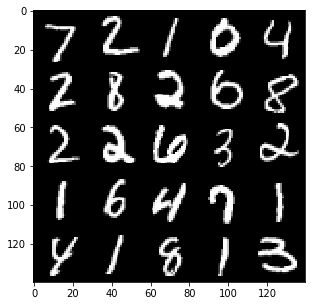

Reconstructed Images


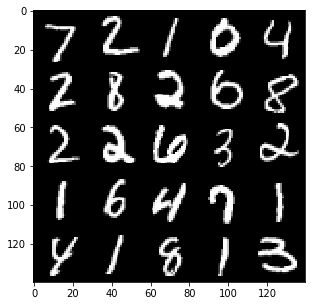

In [11]:
import matplotlib.pyplot as plt

n = 5
canvas_original = np.empty((28 * n, 28 * n))
canvas_reconstructed = np.empty((28 * n, 28 * n))
for i, (batch_x, _) in enumerate(test_data.take(n)):
    reconstructed_images = decoder(encoder(batch_x))
    for j in range(n):
        img = batch_x[j].numpy().reshape([28, 28])
        canvas_original[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = img
    for j in range(n):
        reconstrructed_img = batch_x[j].numpy().reshape([28, 28])
        canvas_reconstructed[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = reconstrructed_img

print("Original Images")
plt.figure(figsize = (n, n))
plt.imshow(canvas_original, origin = "upper", cmap = "gray")
plt.show()

print("Reconstructed Images")
plt.figure(figsize = (n, n))
plt.imshow(canvas_reconstructed, origin = "upper", cmap = "gray")
plt.show()
